In [58]:
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from tabulate import tabulate
from wordcloud_fa import WordCloudFa
import re
from hazm import word_tokenize, stopwords_list, Stemmer
import emoji

from googletrans import Translator

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, TFAutoModel

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.layers as Layers
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# CUDA

In [59]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Read Datasets and Shuffle

In [60]:
train = pd.read_csv('../data/digikala-reviews/original.csv')
test = pd.read_csv('../data/digikala-reviews/test.csv')


In [61]:
train.loc[len(train)] = [train.columns[0], int(train.columns[1])] 
train = train.set_axis(['text', 'label'], axis=1)


test.loc[len(test)] = [test.columns[0], int(test.columns[1])] 
test = test.set_axis(['text', 'label'], axis=1)

In [62]:
train['label'] = train['label'].apply(lambda x: -1 if(x < 0) else 1 if (x > 0) else 0)
test['label'] = test['label'].apply(lambda x: -1 if(x < 0) else 1 if (x > 0) else 0)

In [63]:
NUMCLASS = 3

In [64]:
## Preprocess
def preprocess(x, html = True, url = True, username = False, hashtag = False, rep = False, 
			   stopword = False, punctuation = False, demojize = True, stemming = False):

	if(html):
		x = re.sub(re.compile('<.*?>') , '', x)
	if(url):
		x = re.sub(r'http\S+|www\S+', '', x)
	if(username):
		x = re.sub(r'@[^ ]+', '', x)
	if(hashtag):
		x = re.sub(r'#', '', x)
	if(rep):
		x = re.sub(r'(.)\1+', r'\1', x)
	if(demojize):
		x = emoji.demojize(x, language='fa')
	if(punctuation):
		puncs = [
			'[', '!', '"', '#', '%', '\\', '\"', '(', ')', '*',
			'+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', 
			'/', '^', '_', '`', '{', '|', '}', '~',
			'’', '”', '“', '′', '‘', ']','؟','؛','«','»','،','٪'
		]
		pattern = r'[' + re.escape(''.join(puncs)) + r']'
		x = re.sub(pattern, ' ', x)

	# tokens = word_tokenize(x)
	
	if(stopword):
		stopwords = stopwords_list()
		tokens = [token for token in tokens if token not in stopwords]
	if(stemming):
		stemmer = Stemmer()
		tokens = [stemmer.stem(token) for token in tokens]

	# x = ' '.join(tokens)
	x = x.replace("\u200c", " ")

	return x


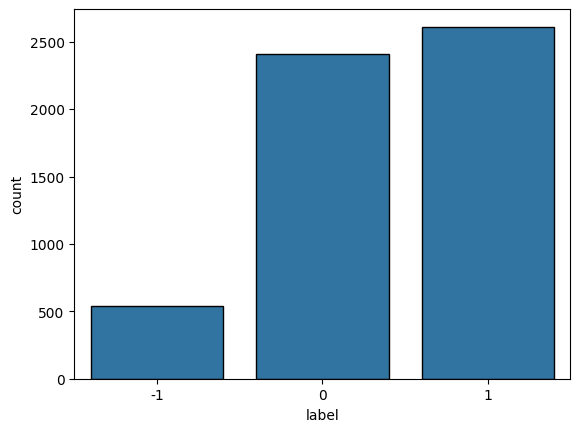

In [65]:
sea.countplot(train, x = 'label', edgecolor ='black')
plt.show()

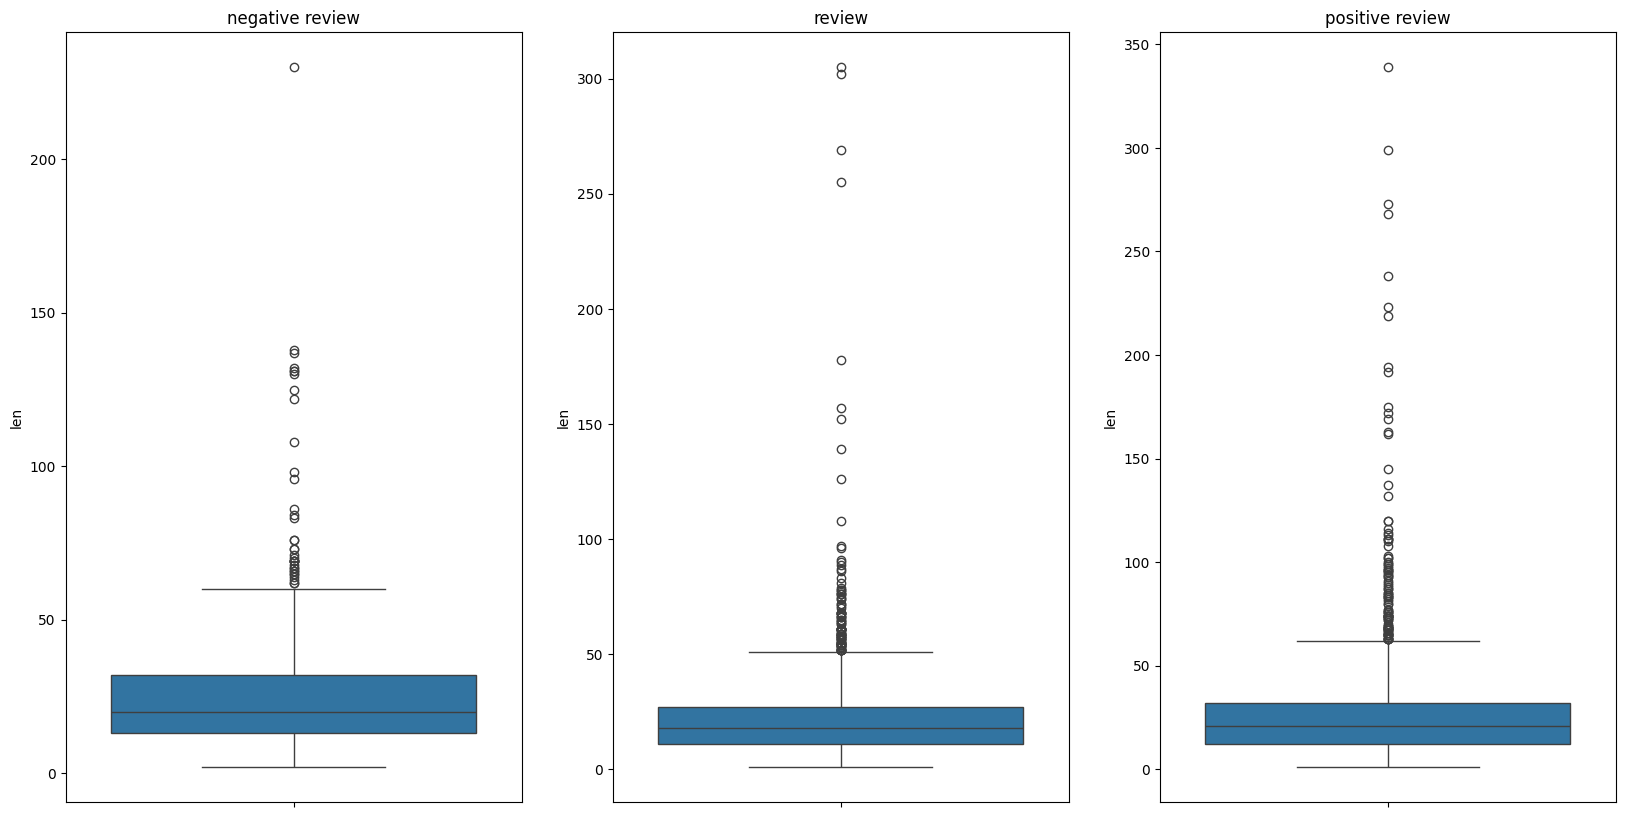

In [66]:
train['clean'] = train['text'].apply(lambda x: preprocess(x))

train['len'] = train['clean'].apply(lambda x: len(word_tokenize(x)))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20, 10))
sea.boxplot(ax=axes[0], y = train[train['label'] == -1]['len']).set_title('negative review')
sea.boxplot(ax=axes[1], y = train[train['label'] == 0]['len']).set_title('review')
sea.boxplot(ax=axes[2], y = train[train['label'] == 1]['len']).set_title('positive review')

plt.show()

In [1]:
# train['clean'] = train['text'].apply(lambda x: preprocess(x, punctuation=True))

# texts = train['clean']
# texts = ' '.join(texts.astype(str))
# wordcloud_combined = WordCloudFa(no_reshape=True, stopwords=stopwords_list(), background_color='white', width=800, height=400, colormap='viridis').generate(texts)
# plt.figure(figsize=(8, 4))
# plt.imshow(wordcloud_combined, interpolation='bilinear')
# plt.axis('off')
# plt.title('All Reviews')

# plt.show()

In [11]:
# from collections import Counter

# # return count(A) - count(B)
# def count_differenc(A: str, B: str):
      
# 	A_counts = Counter(A.split())
# 	B_counts = Counter(B.split())
# 	diff_counts = A_counts.copy()
# 	for word, count in B_counts.items():
# 		diff_counts[word] -= count
# 		if diff_counts[word] <= 0:
# 			del diff_counts[word]

# 	only_A = diff_counts.copy()
# 	for word in diff_counts:
# 		if word in stopwords_list():
# 			del only_A[word]

# 	return only_A

In [12]:
# pos_texts = train[train['label'] == 1]['clean']
# neg_texts = train[train['label'] == -1]['clean']

# pos_texts = ' '.join(pos_texts.astype(str))
# neg_texts = ' '.join(neg_texts.astype(str))

In [13]:
# only_positive = count_differenc(pos_texts, neg_texts)
# only_negative = count_differenc(neg_texts, pos_texts)

# wordcloud_pos = WordCloudFa(no_reshape=True, stopwords=stopwords_list(), width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(only_positive)
# wordcloud_neg = WordCloudFa(no_reshape=True, stopwords=stopwords_list(), width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(only_negative)

# plt.figure(figsize=(15, 8))

# plt.subplot(1, 2, 1)
# plt.imshow(wordcloud_pos, interpolation='bilinear')
# plt.axis('off')
# plt.title('Positive Reviews')

# plt.subplot(1, 2, 2)
# plt.imshow(wordcloud_neg, interpolation='bilinear')
# plt.axis('off')
# plt.title('Negative Reviews')

# plt.show()

# Preparing Data

In [68]:
train['clean'] = train['text'].apply(lambda x: preprocess(x))
test['clean'] = test['text'].apply(lambda x: preprocess(x))

## Create Validation Data

In [69]:
train, valid = train_test_split(train, test_size=0.1, random_state=999)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

## Back Translation

In [70]:
translate = Translator().translate
def back_translate(text: str, lang: str, midlang: str, show_translate = False):
	t = translate(text, src=lang, dest=midlang).text
	if(show_translate):
		print(t)
	b = translate(t, src=midlang, dest=lang).text

	return b

In [73]:
for i in range(20):
	print(i)
	print(train['clean'][i])
	print(back_translate(train['clean'][i], lang='fa', midlang='fr'))
	print('-------------------------------------')

0
اما حافظه داخلی این گوشی 16 گیگابایت است که با پشتیبانی گوشی از کارت حافظه microSD تا 32 گیگابایت دیگر نیز می توان به آن افزود.
اما حافظه داخلی این گوشی 16 گیگابایت است که با پشتیبانی از کارت حافظه میکرو اس دی تا 32 گیگابایت قابل افزایش است.
-------------------------------------
1
متشکرم ديجي کالا
ممنون دیجی کالا
-------------------------------------
2
در ضمن ميتونين به عنوان هارد ديسک اينترنال هم ازش استفاده کنين!
به علاوه، می توانید از آن به عنوان هارد دیسک داخلی استفاده کنید!
-------------------------------------
3
اصلا قصد تبليغات ندارم.
من اصلا قصد تبلیغ ندارم
-------------------------------------
4
از نظر ضبط ویدیویی، فیلم های ضبط شده بسیار شارپ و با کیفیت هستند.
از نظر فیلمبرداری فیلم های ضبط شده بسیار واضح و با کیفیت هستند.
-------------------------------------
5
از اينکه راحت هر برنامه اي را بخواهيد ميتوانيد دانلود کنيد و استفاده کنيد لذت ميبريد.
شما عاشق این واقعیت خواهید بود که می توانید به راحتی هر برنامه ای را که می خواهید دانلود و استفاده کنید.
-------------------------

## Data Augmentation

In [18]:
backtranslated = []

In [56]:
for i in tqdm(range(3775, 5004)):
	t = back_translate(train['clean'][i], lang='fa', midlang='fr')
	backtranslated.append(t)

100%|██████████| 1229/1229 [26:38<00:00,  1.30s/it]


In [58]:
b = pd.DataFrame(columns=['text', 'label'])
b['text'] = backtranslated
b['label'] = train['label'][:5004].values

In [59]:
# b.to_csv('1.csv')

## Load FaBert

In [17]:
bert_tokenizer = AutoTokenizer.from_pretrained('./fabert')
bert_model = TFAutoModel.from_pretrained('./fabert')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

## Tokenize

In [18]:
MAXLEN = 128

In [19]:
def tokenize(texts, tokenizer, maxlen = MAXLEN):
	ids = []
	masks = []
	types = []
	for text in texts:
		o = tokenizer.encode_plus(
			text,
			add_special_tokens=True,
			max_length=maxlen,
			pad_to_max_length=True,
			truncation=True,
			return_tensors='tf',
			verbose=0
		)
		ids.append(o['input_ids'])
		masks.append(o['attention_mask'])
		types.append(o['token_type_ids'])

	return (
		np.array(ids).reshape(len(texts), maxlen),
		np.array(masks).reshape(len(texts), maxlen),
		np.array(types).reshape(len(texts), maxlen)
	)

In [20]:
encoder = OneHotEncoder(sparse_output=False)
def create_datasets(
		tokenizer, train, valid, test, batch_size, maxlen = MAXLEN
):

	train_tokens = tokenize(train['clean'], tokenizer, maxlen)
	valid_tokens = tokenize(valid['clean'], tokenizer, maxlen)
	test_tokens = tokenize(test['clean'], tokenizer, maxlen)


	ytrain = encoder.fit_transform(train['label'].values.reshape(-1, 1))
	yvalid = encoder.transform(valid['label'].values.reshape(-1, 1))

	train_dataset = tf.data.Dataset.from_tensor_slices((
		{'input_ids': train_tokens[0], 'attention_mask': train_tokens[1]},
		ytrain
	))
	train_dataset = train_dataset.shuffle(len(train['label'])).batch(batch_size)

	valid_dataset = tf.data.Dataset.from_tensor_slices((
		{'input_ids': valid_tokens[0], 'attention_mask': valid_tokens[1]},
		yvalid
	))
	valid_dataset = valid_dataset.shuffle(len(valid['label'])).batch(batch_size)

	test_dataset = tf.data.Dataset.from_tensor_slices((
		{'input_ids': test_tokens[0], 'attention_mask': test_tokens[1]}
	)).batch(batch_size)

	return train_dataset, valid_dataset, test_dataset

# Networks

## Utils

In [21]:
def show_model(model):
	model.summary()
	plot_model(
		model,
		show_shapes = True,
		show_dtype=False,
		show_layer_names = True,
		rankdir = 'TB',
		expand_nested = False,
		dpi = 256
	)

In [22]:
def training_metrics(history):

	epochs = range(1, len(history.history['loss']) + 1)

	plt.figure(figsize=(12, 6))
	plt.subplot(1, 2, 1)
	plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
	plt.plot(epochs, history.history['val_loss'], 'b-', label='Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()

	plt.subplot(1, 2, 2)
	plt.plot(epochs, history.history['accuracy'], 'r-', label='Training Accuracy')
	plt.plot(epochs, history.history['val_accuracy'], 'b-', label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.legend()


	plt.tight_layout()
	plt.show()

def test_metrics(y_true, y_pred, labels = [-1, 0, 1]):
	accuracy = accuracy_score(y_true, y_pred)
	precision = precision_score(y_true, y_pred, average=None, labels=labels)
	recall = recall_score(y_true, y_pred, average=None, labels=labels)
	f1 = f1_score(y_true, y_pred, average=None, labels=labels)

	precision_macro = precision_score(y_true, y_pred, average='macro')
	recall_macro = recall_score(y_true, y_pred, average='macro')
	f1_macro = f1_score(y_true, y_pred, average='macro')

	precision_micro = precision_score(y_true, y_pred, average='micro')
	recall_micro = recall_score(y_true, y_pred, average='micro')
	f1_micro = f1_score(y_true, y_pred, average='micro')

	precision_weighted = precision_score(y_true, y_pred, average='weighted')
	recall_weighted = recall_score(y_true, y_pred, average='weighted')
	f1_weighted = f1_score(y_true, y_pred, average='weighted')

	accuracy_table = [["Accuracy", f"{accuracy:.4f}"]]

	class_metrics = []
	for i in labels:
		class_metrics.append([f"Class {i}", f"{precision[i]:.4f}", f"{recall[i]:.4f}", f"{f1[i]:.4f}"])

	average_metrics = [
		["Macro average", f"{precision_macro:.4f}", f"{recall_macro:.4f}", f"{f1_macro:.4f}"],
		["Micro average", f"{precision_micro:.4f}", f"{recall_micro:.4f}", f"{f1_micro:.4f}"],
		["Weighted average", f"{precision_weighted:.4f}", f"{recall_weighted:.4f}", f"{f1_weighted:.4f}"]
	]

	print(tabulate(accuracy_table, headers=["Metric", "Value"], tablefmt="grid"))
	print(tabulate(class_metrics, headers=["Class", "Precision", "Recall", "F1-score"], tablefmt="grid"))
	print(tabulate(average_metrics, headers=["Average Type", "Precision", "Recall", "F1-score"], tablefmt="grid"))

	cm = confusion_matrix(y_true, y_pred, labels=labels)
	plt.figure(figsize=(8, 6))
	sea.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
	plt.title('Confusion Matrix')
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.show()

In [23]:
def create_model(base_model):
	input_ids = Layers.Input(shape=(MAXLEN,), dtype=tf.int32, name="input_ids")
	attention_mask = Layers.Input(shape=(MAXLEN,), dtype=tf.int32, name="attention_mask")
	bert_output = base_model(input_ids, attention_mask=attention_mask)[1]
	dense_output = Layers.Dense(NUMCLASS, activation='softmax')(bert_output)
	model = Model(inputs=[input_ids, attention_mask], outputs=dense_output)

	
	bert_layers = bert_model.layers[0].encoder.layer
	bert_layers[-1].trainable = True
	for i in range(len(bert_layers) - 1):
		bert_layers[i].trainable = False
	return model

### 1. Train Data

In [27]:
model = create_model(bert_model)
show_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  124441344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
	loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
train_dataset, valid_dataset, Xtest = create_datasets(
    bert_tokenizer, 
    batch_size = 4,
    train = train,
    valid = valid,
    test = test
)

Epoch 1/5
1251/1251 [==============================] - 246s 183ms/step - loss: 0.8483 - accuracy: 0.6203 - val_loss: 0.7187 - val_accuracy: 0.6822
Epoch 2/5
1251/1251 [==============================] - 217s 174ms/step - loss: 0.5865 - accuracy: 0.7588 - val_loss: 0.6608 - val_accuracy: 0.7127
Epoch 3/5
1251/1251 [==============================] - 216s 173ms/step - loss: 0.4548 - accuracy: 0.8094 - val_loss: 0.6446 - val_accuracy: 0.7361
Epoch 4/5
1251/1251 [==============================] - 215s 171ms/step - loss: 0.3644 - accuracy: 0.8597 - val_loss: 0.6682 - val_accuracy: 0.7469
Epoch 5/5
1251/1251 [==============================] - 219s 175ms/step - loss: 0.2800 - accuracy: 0.8905 - val_loss: 0.7176 - val_accuracy: 0.7469


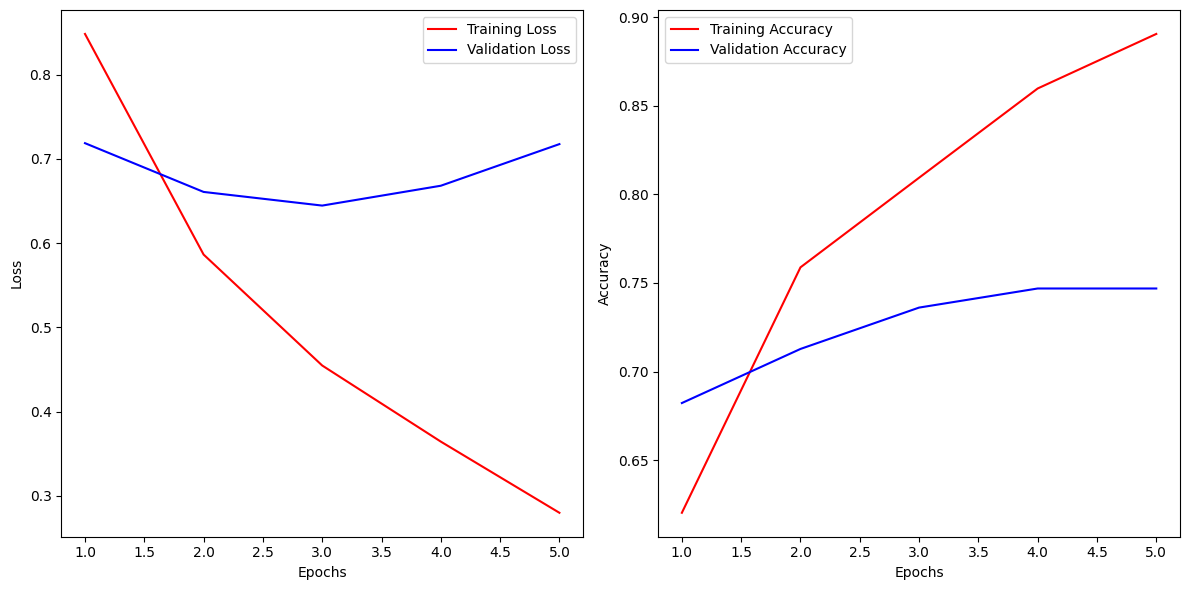

464/464 [==============================] - 34s 65ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.7945 |
+----------+---------+
+----------+-------------+----------+------------+
| Class    |   Precision |   Recall |   F1-score |
+==========+=============+==========+============+
| Class -1 |      0.817  |   0.8732 |     0.8442 |
+----------+-------------+----------+------------+
| Class 0  |      0.7177 |   0.4541 |     0.5563 |
+----------+-------------+----------+------------+
| Class 1  |      0.7779 |   0.7873 |     0.7826 |
+----------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Macro average    |      0.7709 |   0.7049 |     0.7277 |
+------------------+-------------+----------+------------+
| Micro average    |      0.7945 |   0.7945 |     0.7945 |
+--------------

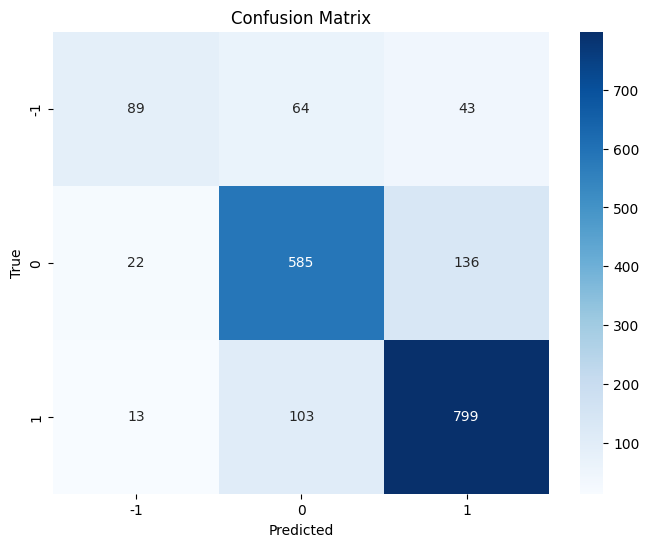

In [30]:
history = model.fit(train_dataset, epochs=5, validation_data=valid_dataset)

training_metrics(history)

y_pred = model.predict(Xtest)
y_pred = np.argmax(y_pred, axis=1) - 1
test_metrics(test['label'], y_pred)

### 2. Augmented Data

In [24]:
augmented = pd.read_csv('1.csv')

In [25]:
train_augmented = pd.concat(
    [train[['clean', 'label']], augmented[['clean', 'label']]], 
    ignore_index = True, 
    sort = False
).drop_duplicates()

In [26]:
model = create_model(bert_model)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
	loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
train_dataset, valid_dataset, Xtest = create_datasets(
    bert_tokenizer, 
    batch_size = 4,
    train = train_augmented,
    valid = valid,
    test = test
)

Epoch 1/5
2403/2403 [==============================] - 421s 169ms/step - loss: 0.7451 - accuracy: 0.6793 - val_loss: 0.6600 - val_accuracy: 0.7199
Epoch 2/5
2403/2403 [==============================] - 395s 164ms/step - loss: 0.4955 - accuracy: 0.8010 - val_loss: 0.6482 - val_accuracy: 0.7397
Epoch 3/5
2403/2403 [==============================] - 395s 164ms/step - loss: 0.3768 - accuracy: 0.8538 - val_loss: 0.6646 - val_accuracy: 0.7540
Epoch 4/5
2403/2403 [==============================] - 396s 165ms/step - loss: 0.2853 - accuracy: 0.8907 - val_loss: 0.7127 - val_accuracy: 0.7522
Epoch 5/5
2403/2403 [==============================] - 391s 163ms/step - loss: 0.1962 - accuracy: 0.9239 - val_loss: 0.7932 - val_accuracy: 0.7540


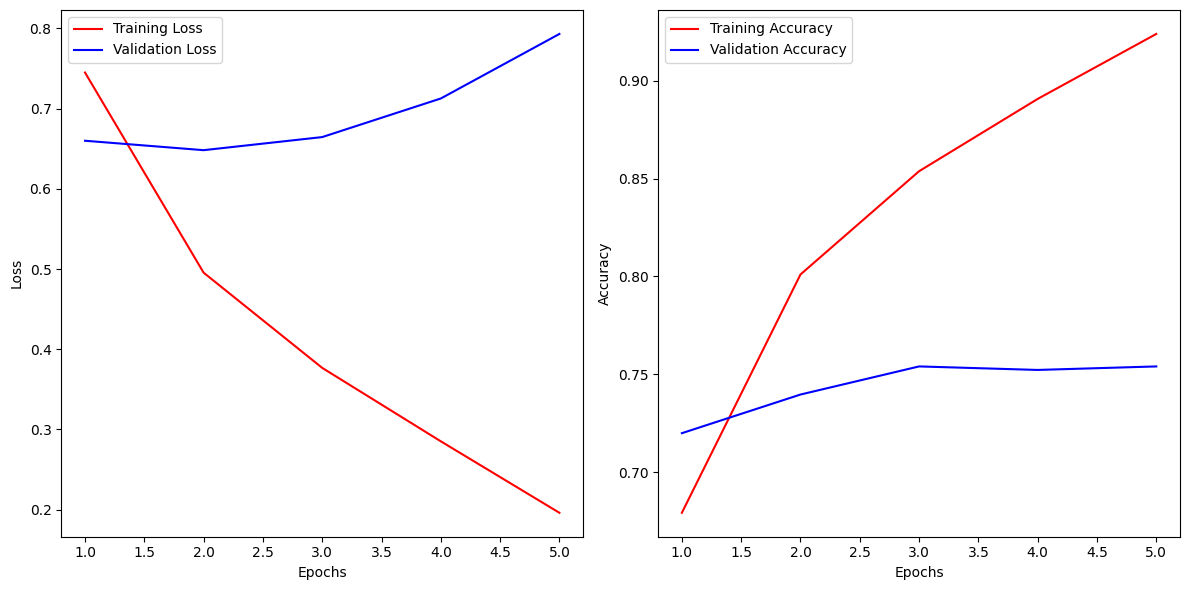

464/464 [==============================] - 31s 62ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.8047 |
+----------+---------+
+----------+-------------+----------+------------+
| Class    |   Precision |   Recall |   F1-score |
+==========+=============+==========+============+
| Class -1 |      0.8725 |   0.823  |     0.847  |
+----------+-------------+----------+------------+
| Class 0  |      0.7029 |   0.6276 |     0.6631 |
+----------+-------------+----------+------------+
| Class 1  |      0.7549 |   0.8291 |     0.7903 |
+----------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Macro average    |      0.7768 |   0.7599 |     0.7668 |
+------------------+-------------+----------+------------+
| Micro average    |      0.8047 |   0.8047 |     0.8047 |
+--------------

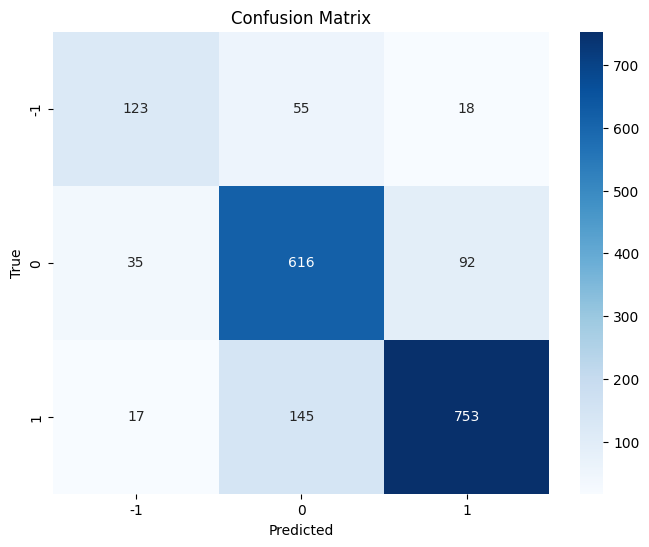

In [28]:
history = model.fit(train_dataset, epochs=5, validation_data=valid_dataset)

training_metrics(history)

y_pred = model.predict(Xtest)
y_pred = np.argmax(y_pred, axis=1) - 1
test_metrics(test['label'], y_pred)